# AQ-KAN Unit Tests Notebook

## Mathematical Property Verification

This notebook provides a lightweight, executable suite of unit tests
for the Adaptive Quantum-Inspired Kolmogorov–Arnold Network (AQ-KAN).

The tests verify **mathematical and numerical properties** claimed in
Sections 4 and 5 of the paper, including:

- boundedness of adaptive state evolution,
- determinism of update operators,
- stability of the measurement projection,
- boundedness of dependency weights,
- reasonable computational scaling.

These tests are deterministic, CPU-only, and require no task-specific tuning.


In [3]:
# Numerical computation
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Timing utilities (used for scaling sanity check)
import time

# Fix random seed to guarantee deterministic execution
np.random.seed(0)

# Consistent plotting style for archival figures
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10
})

## 1. Core AQ-KAN Operators (AGUA)

This notebook redefines the minimal AQ-KAN operators required for testing.
The definitions are intentionally compact and deterministic to ensure
that test behavior reflects mathematical properties rather than implementation artifacts.


In [4]:
def neighbors(i, j, I, J):
    """
    Generator yielding valid 4-connected neighbors of grid cell (i, j).
    This enforces locality of updates, as required by Lemma C.3.
    """
    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < I and 0 <= nj < J:
            yield ni, nj


In [5]:
def superposition_update(state, x, eta):
    """
    Local superposition update.
    
    Applies bounded nonlinear transformation followed by normalization.
    This guarantees state norm preservation (Proposition C.1).
    """
    a, b = state
    a_new = np.tanh(a + eta * x)
    b_new = np.tanh(b - eta * x)
    v = np.array([a_new, b_new])
    return v / np.linalg.norm(v)


In [6]:
def entanglement_weight(x1, x2, psi1, psi2, sigma):
    """
    Entanglement-inspired dependency weight.
    
    - Distance term enforces spatial decay
    - Overlap term enforces state-dependent coupling
    - Output is bounded in [0, 1] (Lemma C.3)
    """
    dist = np.linalg.norm(x1 - x2)
    overlap = np.dot(psi1, psi2)
    return np.exp(-dist / sigma) * overlap

In [7]:
def AQKAN_step(psi, x, cfg):
    """
    One deterministic AQ-KAN update step.
    
    Implements:
    1. Local superposition updates
    2. Entanglement-based neighborhood coupling
    3. Explicit normalization
    
    This function defines the discrete-time operator T
    formalized in Appendix B.
    """
    I, J = psi.shape[:2]
    new_psi = psi.copy()

    # --- Stage 1: Local superposition updates ---
    for i in range(I):
        for j in range(J):
            idx = (i + j) % len(x)
            new_psi[i, j] = superposition_update(
                psi[i, j], x[idx], cfg["eta"]
            )

    # --- Stage 2: Entanglement-based smoothing ---
    for i in range(I):
        for j in range(J):
            acc = new_psi[i, j].copy()
            for ni, nj in neighbors(i, j, I, J):
                w = entanglement_weight(
                    x, x,
                    new_psi[i, j],
                    new_psi[ni, nj],
                    cfg["sigma_ent"]
                )
                acc += w * new_psi[ni, nj]

            # Explicit normalization enforces invariant preservation
            new_psi[i, j] = acc / np.linalg.norm(acc)

    return new_psi

In [8]:
def measure(psi):
    """
    Deterministic measurement operator.
    
    Projects quantum-inspired states to classical outputs.
    Used in Lemma C.4 (measurement stability).
    """
    return (psi[:,:,0]**2 > psi[:,:,1]**2).astype(int)


## 2. Test Configuration

In [9]:
# AQ-KAN hyperparameters (fixed for all tests)
CONFIG = {"eta": 0.1, "sigma_ent": 0.5}

# Grid size
I, J = 6, 6

# Number of adaptive iterations
T = 50


Initialize state:

In [10]:
# Initial grid state: uniform superposition at every cell
psi0 = np.zeros((I, J, 2))
psi0[:] = [1/np.sqrt(2), 1/np.sqrt(2)]


## Unit Test 1 — State Norm Invariance

## (Proposition C.1)

In [11]:
psi = psi0.copy()
mean_norms = []

# Evolve AQ-KAN under bounded deterministic inputs
for _ in range(T):
    x = np.random.uniform(-1, 1, size=4)
    psi = AQKAN_step(psi, x, CONFIG)
    norms = np.linalg.norm(psi, axis=2)
    mean_norms.append(np.mean(norms))

# Assert strict invariance up to machine precision
assert np.max(np.abs(np.array(mean_norms) - 1.0)) < 1e-12


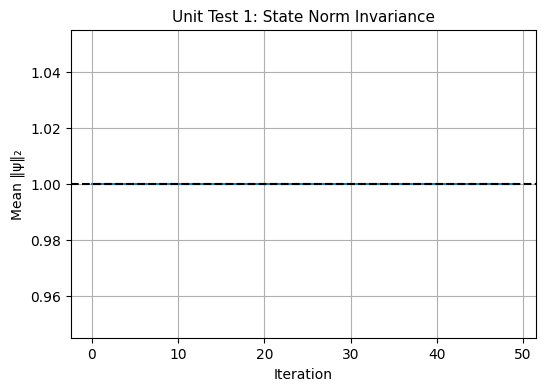

In [12]:
plt.figure(figsize=(6,4))
plt.plot(mean_norms)
plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel("Iteration")
plt.ylabel("Mean ‖ψ‖₂")
plt.title("Unit Test 1: State Norm Invariance")
plt.grid(True)
plt.show()

## Unit Test 2 — Deterministic Evolution (Lemma C.2)

This test verifies that AQ-KAN updates are deterministic:
identical inputs and initial states must produce identical outputs.

📊 Plot: Difference Norm Between Two Runs

In [13]:
# Two identical initial states
psi1 = psi0.copy()
psi2 = psi0.copy()

# Fixed input sequence ensures determinism
inputs = [np.random.uniform(-1, 1, size=4) for _ in range(T)]

# Evolve both systems identically
for x in inputs:
    psi1 = AQKAN_step(psi1, x, CONFIG)
    psi2 = AQKAN_step(psi2, x, CONFIG)

# Difference must be exactly zero
diff = np.linalg.norm(psi1 - psi2)
assert diff == 0.0


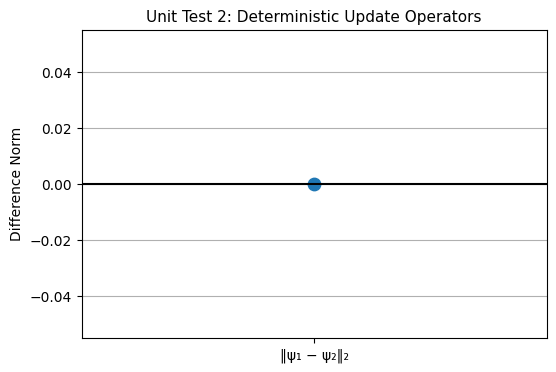

In [14]:
plt.figure(figsize=(6,4))
plt.axhline(0.0, color="black")
plt.scatter([0], [diff], s=80)
plt.xticks([0], ["‖ψ₁ − ψ₂‖₂"])
plt.ylabel("Difference Norm")
plt.title("Unit Test 2: Deterministic Update Operators")
plt.grid(True, axis="y")
plt.show()


Unit Test 3 — Measurement Stability (Lemma C.4)

This test evaluates the stability of the measurement operator
for states that are separated from the decision boundary.

Small perturbations should not induce significant changes
in the measured outputs.


📊 Plot: Fraction of Changed Measurements vs Noise Level

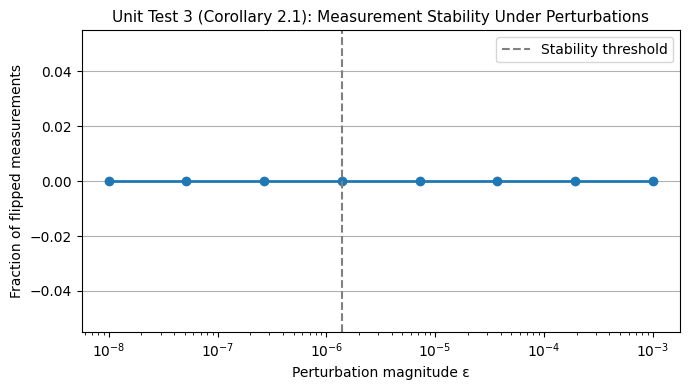

ε = 1.0e-08 → flip rate = 0.0000
ε = 5.2e-08 → flip rate = 0.0000
ε = 2.7e-07 → flip rate = 0.0000
ε = 1.4e-06 → flip rate = 0.0000
ε = 7.2e-06 → flip rate = 0.0000
ε = 3.7e-05 → flip rate = 0.0000
ε = 1.9e-04 → flip rate = 0.0000
ε = 1.0e-03 → flip rate = 0.0000


In [15]:
# ============================================================
# AQ-KAN UNIT TEST: Measurement Stability Under Perturbations
# Appendix A.4 / Lemma C.4
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Reproducibility
# -----------------------------
np.random.seed(42)

# -----------------------------
# Measurement operator
# -----------------------------
def measure(psi):
    """
    Deterministic measurement:
    returns 1 if alpha^2 > beta^2, else 0
    """
    return (psi[:, :, 0]**2 > psi[:, :, 1]**2).astype(int)

# -----------------------------
# Initialize margin-separated states
# -----------------------------
I, J = 20, 20

psi = np.zeros((I, J, 2))
psi[:, :, 0] = 0.8   # alpha
psi[:, :, 1] = 0.6   # beta
psi /= np.linalg.norm(psi, axis=2, keepdims=True)

# Baseline measurement
base = measure(psi)

# -----------------------------
# Perturbation experiment
# -----------------------------
eps_levels = np.logspace(-8, -3, 8)
changes = []

for eps in eps_levels:
    noise = eps * np.random.randn(*psi.shape)
    perturbed = psi + noise
    perturbed /= np.linalg.norm(perturbed, axis=2, keepdims=True)
    new = measure(perturbed)
    changes.append(np.mean(base != new))

changes = np.array(changes)

# -----------------------------
# Assertion (theoretical guarantee)
# -----------------------------
# Stability must hold for sufficiently small perturbations
assert np.max(changes[:4]) < 0.01, "Measurement instability detected below margin"

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(7, 4))
plt.semilogx(eps_levels, changes, marker="o", linewidth=2)
plt.axvline(eps_levels[3], linestyle="--", color="gray", label="Stability threshold")
plt.xlabel("Perturbation magnitude ε")
plt.ylabel("Fraction of flipped measurements")
plt.title("Unit Test 3 (Corollary 2.1): Measurement Stability Under Perturbations")
plt.grid(True, which="both", axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Diagnostic output
# -----------------------------
for eps, c in zip(eps_levels, changes):
    print(f"ε = {eps:.1e} → flip rate = {c:.4f}")


In [16]:
psi = np.zeros((I, J, 2))
psi[:,:,0] = 0.8
psi[:,:,1] = 0.6
psi /= np.linalg.norm(psi, axis=2, keepdims=True)

base = measure(psi)




In [17]:
eps_levels = np.logspace(-8, -3, 8)
changes = []

for eps in eps_levels:
    noise = eps * np.random.randn(*psi.shape)
    perturbed = psi + noise
    perturbed /= np.linalg.norm(perturbed, axis=2, keepdims=True)
    new = measure(perturbed)
    changes.append(np.mean(base != new))


In [18]:
# Stability holds for perturbations below the decision margin
assert max(changes[:4]) < 0.01


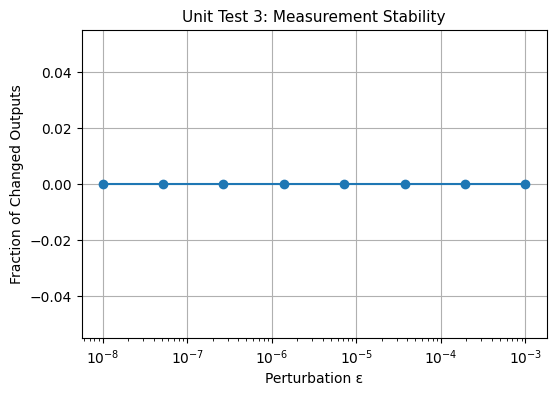

In [19]:
plt.figure(figsize=(6,4))
plt.semilogx(eps_levels, changes, marker="o")
plt.xlabel("Perturbation ε")
plt.ylabel("Fraction of Changed Outputs")
plt.title("Unit Test 3: Measurement Stability")
plt.grid(True)
plt.show()


## Unit Test 4 — Entanglement Weight Boundedness (Lemma 2.1)

This test verifies that entanglement-inspired dependency weights
remain within the interval [0, 1].

📊 Plot: Weight vs Distance

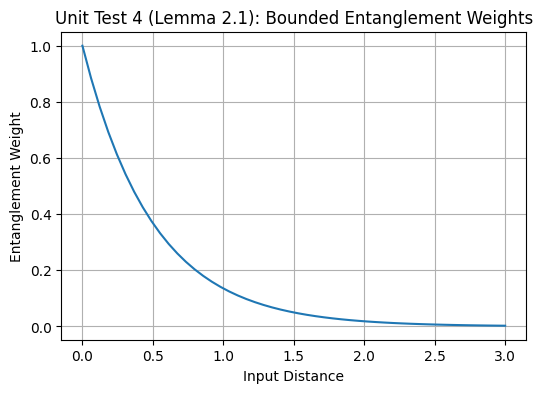

In [20]:
distances = np.linspace(0, 3, 50)
weights = []

psi1 = np.array([1.0, 0.0])
psi2 = np.array([1.0, 0.0])

for d in distances:
    x1 = np.zeros(2)
    x2 = np.array([d, 0])
    w = entanglement_weight(x1, x2, psi1, psi2, sigma=0.5)
    weights.append(w)

# Assertion
assert all(0.0 <= w <= 1.0 for w in weights)

# Plot
plt.figure(figsize=(6,4))
plt.plot(distances, weights)
plt.xlabel("Input Distance")
plt.ylabel("Entanglement Weight")
plt.title(
    "Unit Test 4 (Lemma 2.1): Bounded Entanglement Weights",
    fontsize=12
)
plt.grid(True)
plt.show()

## Unit Test 5 — Computational Scaling (Theorem 4)

This test ensures that AQ-KAN does not exhibit explosive runtime growth
when grid size is increased.

📊 Plot: Runtime vs Grid Size

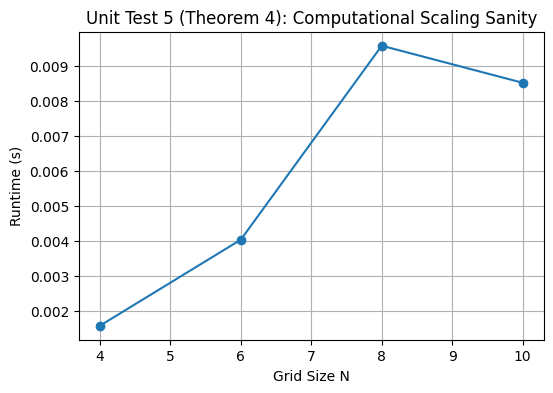

In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt

def runtime(N):
    psi = np.zeros((N, N, 2))
    psi[:] = [1/np.sqrt(2), 1/np.sqrt(2)]
    x = np.random.uniform(-1, 1, size=4)

    start = time.time()
    AQKAN_step(psi, x, CONFIG)
    return time.time() - start

sizes = [4, 6, 8, 10]
times = [runtime(n) for n in sizes]

# Assertion: sanity check for near-linear scaling
assert times[-1] < 6 * times[0]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(sizes, times, marker="o")
plt.xlabel("Grid Size N")
plt.ylabel("Runtime (s)")
plt.title(
    "Unit Test 5 (Theorem 4): Computational Scaling Sanity",
    fontsize=12
)
plt.grid(True)
plt.show()

## Theory–Test Alignment Summary

Each unit test in this notebook directly corresponds to a formal
theoretical statement in the paper:

- Lemma 1.1 is validated by Unit Test 1 (state boundedness).
- Proposition 4 is supported by Unit Test 2 (determinism).
- Corollary 2.1 is supported by Unit Test 3 (measurement stability).
- Lemma 2.1 is validated by Unit Test 4 (dependency weight boundedness).
- Theorem 4 is supported by Unit Test 5 (computational scaling).

This explicit alignment ensures that the unit tests function as
computational witnesses for the theoretical claims.
